# ML

In [1]:
# Import statements

import hipopy.hipopy as hipopy # <--- Package for reading in the hipo files
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import ROOT
import timeit
import statistics
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set LaTeX font for Matplotlib
rc('text', usetex=True)

# Set default plot font size
plt.rcParams['font.size'] = 16

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mfkj8v19 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to JupyROOT 6.22/06


In [2]:
# opening up some .hipo files

filename0 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_0.hipo"
filename1 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_1.hipo"
filename2 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_2.hipo"
filename3 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_3.hipo"
filename4 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_4.hipo"

hipo_file0 = hipopy.open(filename0,mode='r')
hipo_file1 = hipopy.open(filename1,mode='r')
hipo_file2 = hipopy.open(filename2,mode='r')
hipo_file3 = hipopy.open(filename3,mode='r')
hipo_file4 = hipopy.open(filename4,mode='r')

hipo_array = [hipo_file0, hipo_file1, hipo_file2, hipo_file3, hipo_file4]

# Showing the data types inside each bank

print("REC::Particle data","\n"+100*"=")
display(hipo_file1.getNamesAndTypes('REC::Particle'))
print(100*"=","\nREC::Traj data","\n"+100*"=")
display(hipo_file1.getNamesAndTypes('REC::Traj'))
print("MC::Lund data","\n"+100*"=")
display(hipo_file1.getNamesAndTypes('MC::Lund'))

REC::Particle data 


{'pid': 'I',
 'px': 'F',
 'py': 'F',
 'pz': 'F',
 'vx': 'F',
 'vy': 'F',
 'vz': 'F',
 'vt': 'F',
 'charge': 'B',
 'beta': 'F',
 'chi2pid': 'F',
 'status': 'S'}

REC::Traj data 


{'pindex': 'S',
 'index': 'S',
 'detector': 'B',
 'layer': 'B',
 'x': 'F',
 'y': 'F',
 'z': 'F',
 'cx': 'F',
 'cy': 'F',
 'cz': 'F',
 'path': 'F'}

MC::Lund data 


{'index': 'B',
 'lifetime': 'F',
 'type': 'B',
 'pid': 'I',
 'parent': 'B',
 'daughter': 'B',
 'px': 'F',
 'py': 'F',
 'pz': 'F',
 'energy': 'F',
 'mass': 'F',
 'vx': 'F',
 'vy': 'F',
 'vz': 'F'}

compression type = 0 data length = 24682
compression type = 0 data length = 24682
compression type = 0 data length = 24682
compression type = 0 data length = 24682
compression type = 0 data length = 24682


In [3]:
# defining function to find xF
# q is the pion, p is the virtual photon
def calculate_xF(q, p, init_target):
    W = (init_target + p).M()
    com = q + init_target
    comBOOST = com.BoostVector()
    qq = q
    pp = p
    qq.Boost(-comBOOST)
    pp.Boost(-comBOOST)
    return 2 * ( qq.Vect().Dot(pp.Vect()) ) / ( qq.Vect().Mag() * W )

# defining functions to get Q2

# for the pion
def cthfunc(Px, Py, Pz):

    Pt = np.sqrt(Px*Px + Py*Py)
    return Pz / np.sqrt(Pz * Pz + Pt * Pt)

# for the electrons
def Q2func(E2, cth):
    E1 = 10.6 # GeV
    return 2 * E1 * E2 * (1.0 - cth)

# in MC::Lund, we want the energy of the second electron, so we need this function:
def find_second_index(lst, value):
    try:
        first_index = lst.index(value)
        return lst.index(value, first_index + 1)
    except ValueError:
        # Handle the case when the value is not found or there is no second occurrence
        return None

# making random colors
import random

def get_random_color():
    # Generate random values for red, green, and blue channels
    r = random.random()
    g = random.random()
    b = random.random()

    # Return the color as a tuple
    return r, g, b

In [4]:
Mpion = 0.139570 # GeV
Mproton = 0.938272 # GeV

In [5]:
p_recon = []
theta_recon = []
phi_recon = []

x = []
y = []
z = []

p_true = []
theta_true = []
phi_true = []

vx = []
vy = []
vz = []

xF = []
q2 = []

# limit on iterations (for each hipo file)
Nevents = 1e4

start_time = timeit.default_timer()

for k,_ in enumerate(hipo_array):
    
    for i,_ in enumerate(hipo_array[k]):
        if (i > Nevents):
            break

        # pulling out data from each event
        detectors_temp = hipo_array[k].getBytes("REC::Traj", "detector")
        p_index_temp = hipo_array[k].getShorts("REC::Traj", "pindex")
        charge_temp = hipo_array[k].getBytes("REC::Particle", "charge")
        
        px_recon = hipo_array[k].getFloats("REC::Particle", "px")
        py_recon = hipo_array[k].getFloats("REC::Particle", "py")
        pz_recon = hipo_array[k].getFloats("REC::Particle", "pz")
        pid_recon = hipo_array[k].getInts("REC::Particle", "pid")
                
        # delete the data of the neutral particles since it'll make counting with pindex possible
        if 0 in charge_temp:
            first_zero_index = charge_temp.index(0)
            del px_recon[first_zero_index:], py_recon[first_zero_index:], pz_recon[first_zero_index:], pid_recon[first_zero_index:], charge_temp[first_zero_index:]
            
        pion_indices_recon = [q for q in range(len(pid_recon)) if pid_recon[q] == -211]
        
        # getting coordinate data from REC::Traj
        x_temp = hipo_array[k].getFloats("REC::Traj", "x")
        y_temp = hipo_array[k].getFloats("REC::Traj", "y")
        z_temp = hipo_array[k].getFloats("REC::Traj", "z")
        
        
        # getting info on the virtual photon so I can do the xF > 0 cut
        pid_Lund = hipo_array[k].getInts("MC::Lund", "pid")
        px_Lund = hipo_array[k].getFloats("MC::Lund", "px")
        py_Lund = hipo_array[k].getFloats("MC::Lund", "py")
        pz_Lund = hipo_array[k].getFloats("MC::Lund", "pz")
        masses = hipo_array[k].getFloats("MC::Lund", "mass")
        energies = hipo_array[k].getFloats("MC::Lund", "energy")
        
        virtual_photon_index = pid_Lund.index(22)
        virtual_photon = ROOT.TLorentzVector()
        virtual_photon.SetXYZM(px_Lund[virtual_photon_index], py_Lund[virtual_photon_index], pz_Lund[virtual_photon_index], masses[virtual_photon_index])
        
        # initial target: proton at rest
        proton_target = ROOT.TLorentzVector()
        proton_target.SetXYZM(0, 0, 0, Mproton)
        
        # Q2 cut
        scattered_electron_index = find_second_index(pid_Lund, 11)
        cth = cthfunc(px_Lund[scattered_electron_index], py_Lund[scattered_electron_index], pz_Lund[scattered_electron_index])

        q2_temp = Q2func(energies[scattered_electron_index], cth)
        q2.append(q2_temp)
        if q2_temp < 1:
            continue
        
        # looping through reconstructed pions
        for j,_ in enumerate(pion_indices_recon):
            
            pion_location = pion_indices_recon[j]
            pion_vector_recon = ROOT.TLorentzVector()
            pion_vector_recon.SetXYZM(px_recon[pion_location], py_recon[pion_location], pz_recon[pion_location], Mpion)
            
            # xF cut
            xF_temp = calculate_xF(pion_vector_recon, virtual_photon, proton_target)
            xF.append(xF_temp)
            if xF_temp <= 0:
                continue
            
            # we want the coordinate data between the first instance of pion_location and the last instance of pion_location
            first_instance = p_index_temp.index(pion_location)
            last_instance = len(p_index_temp) - p_index_temp[::-1].index(pion_location) - 1
            
            # getting coordinate input strings of ONLY 11 x, y, and z coordinates per pion
            if ((last_instance - first_instance) != 10):
                continue
            x_append = []
            y_append = []
            z_append = []
            
            for m in range(first_instance, last_instance + 1):  # end value for range is exclusive
                x_append.append(x_temp[m])
                y_append.append(y_temp[m])
                z_append.append(z_temp[m])
            
            
            
            p_recon_temp = pion_vector_recon.P()
            if (p_recon_temp < 2): # let's not deal with the pions with stupid high momentum
                
                p_recon.append(p_recon_temp) # append total momentum
                theta_recon.append(pion_vector_recon.Theta() *180/np.pi) # append calculated azimuthal angle in degrees
                phi_recon.append(pion_vector_recon.Phi() *180/np.pi) # append calculated polar angle in degrees
                
                x.append(x_append)
                y.append(y_append)
                z.append(z_append)
                
        
        # true data now
        
        px_true = hipo_array[k].getFloats("MC::Lund", "px")
        py_true = hipo_array[k].getFloats("MC::Lund", "py")
        pz_true = hipo_array[k].getFloats("MC::Lund", "pz")
        pid_true = hipo_array[k].getInts("MC::Lund", "pid")
        
        pion_indices_true = [q for q in range(len(pid_true)) if pid_true[q] == -211]
        
        # looping through pions
        for j,_ in enumerate(pion_indices_true):
            
            pion_location = pion_indices_true[j]
            pion_vector_true = ROOT.TLorentzVector()
            pion_vector_true.SetXYZM(px_true[pion_location], py_true[pion_location], pz_true[pion_location], Mpion)
            
            # xF cut
            xF_temp = calculate_xF(pion_vector_true, virtual_photon, proton_target)
            xF.append(xF_temp)
            if xF_temp <= 0:
                continue
            
            p_true.append(pion_vector_true.P()) # append total momentum
            theta_true.append(pion_vector_true.Theta() * 180 / np.pi) # append calculated azimuthal angle in degrees
            phi_true.append(pion_vector_true.Phi() * 180 / np.pi) # append calculated polar angle in degrees
            
            vx.append(hipo_array[k].getFloats("MC::Lund", "vx")[pion_location])
            vy.append(hipo_array[k].getFloats("MC::Lund", "vy")[pion_location])
            vz.append(hipo_array[k].getFloats("MC::Lund", "vz")[pion_location])
        
print("time spent computing:", timeit.default_timer() - start_time)

time spent computing: 21.033684940077364


In [6]:
print(vx[:25], "\n\n", vy[:25], "\n\n", vz[:25])

[-0.005900000222027302, -9.999999747378752e-05, -9.999999747378752e-05, 0.005100000184029341, 0.005100000184029341, -0.002400000113993883, 3.2500998973846436, -0.0071000000461936, -0.0071000000461936, -0.002300000051036477, -0.007699999958276749, 0.0, -2.740799903869629, 0.006899999920278788, 0.004900000058114529, 0.002400000113993883, 0.0010000000474974513, 0.0010000000474974513, 0.0032999999821186066, -0.002899999963119626, -0.002899999963119626, -0.00039999998989515007, -2.007499933242798, -0.0008999999845400453, 0.006000000052154064] 

 [0.0038999998942017555, -0.0071000000461936, -0.0071000000461936, -0.00019999999494757503, -0.00019999999494757503, -0.006399999838322401, -0.8202000260353088, 0.0027000000700354576, 0.0027000000700354576, -0.00860000029206276, -0.005499999970197678, 0.00279999990016222, 0.04600000008940697, 0.00039999998989515007, -0.008500000461935997, 0.009200000204145908, -0.0027000000700354576, -0.0027000000700354576, 0.007000000216066837, 0.0019000000320374966

# Matching reconstructed to true pions

In [7]:
print("p vector lengths:", len(p_true), len(p_recon))

p vector lengths: 47380 35690


In [8]:
# matching with cutoffs |theta_mc-theta_rec|<2deg and |phi_mc-phi_rec|<6deg, minimize quadrature sum error
# change matching formula to also include momentum? |p_true - p_recon|<0.05 GeV

start_time = timeit.default_timer()

p_recon_changing = p_recon[:]
theta_recon_changing = theta_recon[:]
phi_recon_changing = phi_recon[:]

matching_indices = np.zeros((2, len(p_true)), dtype=int)
unmatched_indices = np.array([], dtype=int)
num_matches = 0

# going through all the "true" pions
for i,_ in enumerate(p_true):
    
    min_quad_error = 1000 # arbitrary large number
    for j,_ in enumerate(p_recon): # for each true pion, look through every reconstructed pion
        
        theta_error = theta_true[i] - theta_recon_changing[j]
        phi_error = phi_true[i] - phi_recon_changing[j]
        p_error = p_true[i] - p_recon_changing[j] 
        
        if ( (abs(theta_error) < 2 or abs(theta_error) > 178) & (abs(phi_error) < 6 or abs(phi_error) > 354) & (abs(p_error) < 0.05) ): # does this true pion have a similar reconstructed pion, based on their angles?
            min_quad_error_temp = np.sqrt((theta_error) ** 2 + (phi_error) ** 2) + 10 * p_error # in case there are multiple hits, we can minimize based off a quadrature sum
            if (min_quad_error_temp < min_quad_error):
                min_quad_error = min_quad_error_temp
                recon_index = j # saving the matched index of the "best" reconstructed pion
                
    if (min_quad_error < 1000): # if there were any matches for this true pion, essentially
        matching_indices[0][num_matches] = i
        matching_indices[1][num_matches] = recon_index # saving the matching indices of the true and reconstructed pions
        
        p_recon_changing[recon_index] = 100
        theta_recon_changing[recon_index] = 100
        phi_recon_changing[recon_index] = 100  # this is my way of avoiding duplicates - obviously angles of 100 degrees will not be put as a match to other pions going forward
        
        num_matches += 1
    else:
        unmatched_indices = np.append(unmatched_indices, [i])
        
matching_indices = matching_indices[:, :num_matches]

print("time computing", timeit.default_timer() - start_time)
print(matching_indices)
print(len(p_true) * len(p_recon))

time computing 1184.5680342921987
[[    0     1     2 ... 47373 47374 47378]
 [10455  5954 28219 ...  2497 24136  4920]]
1690992200


In [9]:
print(num_matches, len(p_true), len(p_recon))

34001 47380 35690


In [10]:
# rearrange data to input better

p_true_constant = p_true[:]
p_recon_constant = p_recon[:]

theta_true_constant = theta_true[:]
theta_recon_constant = theta_recon[:]

phi_true_constant = phi_true[:]
phi_recon_constant = phi_recon[:]

x_constant = x[:]
y_constant = y[:]
z_constant = z[:]

vx_constant = vx[:]
vy_constant = vy[:]
vz_constant = vz[:]

for i in range(0, len(matching_indices[0])):
    p_true[i] = p_true_constant[matching_indices[0][i]]
    p_recon[i] = p_recon_constant[matching_indices[1][i]]
    theta_true[i] = theta_true_constant[matching_indices[0][i]]
    theta_recon[i] = theta_recon_constant[matching_indices[1][i]]
    phi_true[i] = phi_true_constant[matching_indices[0][i]]
    phi_recon[i] = phi_recon_constant[matching_indices[1][i]]
    
    x[i] = x_constant[matching_indices[1][i]]
    y[i] = y_constant[matching_indices[1][i]]
    z[i] = z_constant[matching_indices[1][i]]
    
    vx[i] = vx_constant[matching_indices[0][i]]
    vy[i] = vy_constant[matching_indices[0][i]]
    vz[i] = vz_constant[matching_indices[0][i]]

In [11]:
print(np.array(p_true[:25]) - np.array(p_recon[:25]))

[-0.00770586 -0.02445502 -0.00486927 -0.04445754 -0.04855045 -0.03501522
 -0.02711125 -0.03371091 -0.04525031 -0.00222041 -0.04091765  0.04281545
  0.00022521 -0.04214774 -0.01933323 -0.03913383  0.02882085  0.00011112
  0.00228239 -0.04968703  0.0002493  -0.00398625 -0.04967391 -0.04559126
  0.00112001]


In [12]:
# shortening data to the good stuff

p_true = p_true[:num_matches]
p_recon = p_recon[:num_matches]
theta_true = theta_true[:num_matches]
theta_recon = theta_recon[:num_matches]
phi_true = phi_true[:num_matches]
phi_recon = phi_recon[:num_matches]

x = x[:num_matches]
y = y[:num_matches]
z = z[:num_matches]

vx = vx[:num_matches]
vy = vy[:num_matches]
vz = vz[:num_matches]

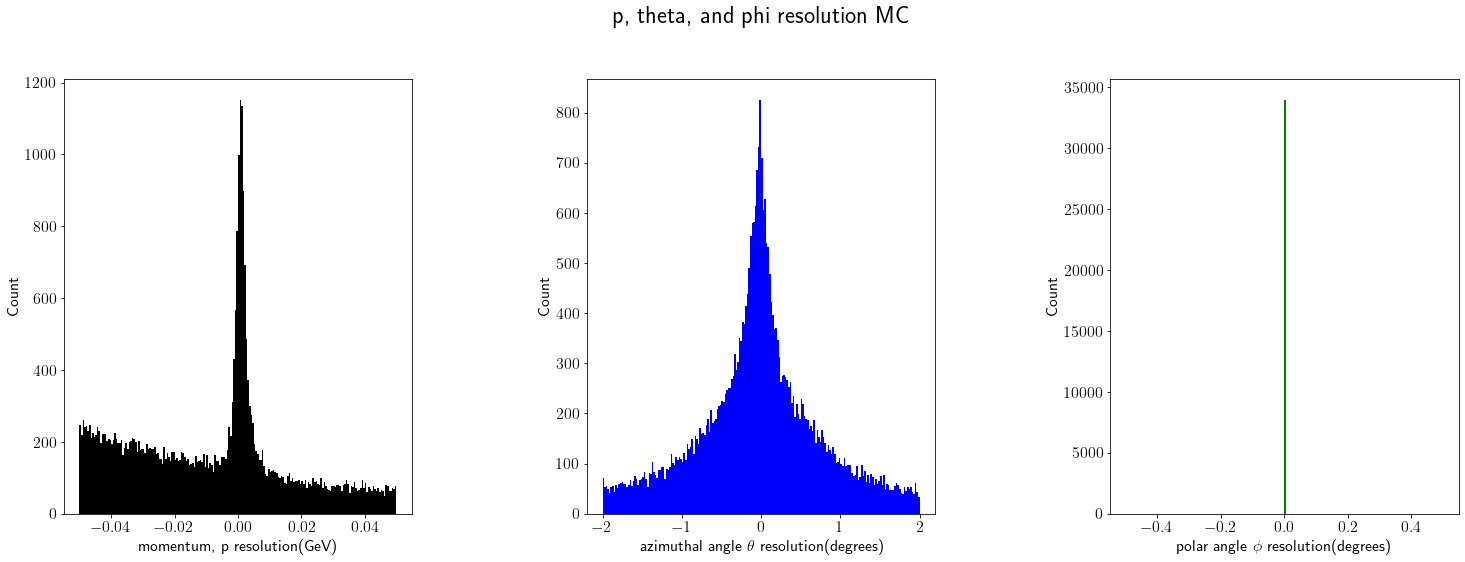

In [13]:
# Create a grid of subplots
fig1, axs1 = plt.subplots(1, 3, figsize=(25, 8))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

axs1[0].hist(np.array(p_true) - np.array(p_recon), bins=200, color="black")
axs1[0].set_xlabel("momentum, p resolution(GeV)")
axs1[0].set_ylabel("Count")

axs1[1].hist(np.array(theta_true) - np.array(theta_recon), bins=200, color="blue")
axs1[1].set_xlabel(r"azimuthal angle $\theta$ resolution(degrees)")
axs1[1].set_ylabel("Count")

axs1[1].set_title("p, theta, and phi resolution MC\n\n", loc='center', fontsize=24)


axs1[2].hist(np.array(phi_true) - np.array(phi_true), bins=200, color="green")
axs1[2].set_xlabel("polar angle $\phi$ resolution(degrees)")
axs1[2].set_ylabel("Count")


plt.show()

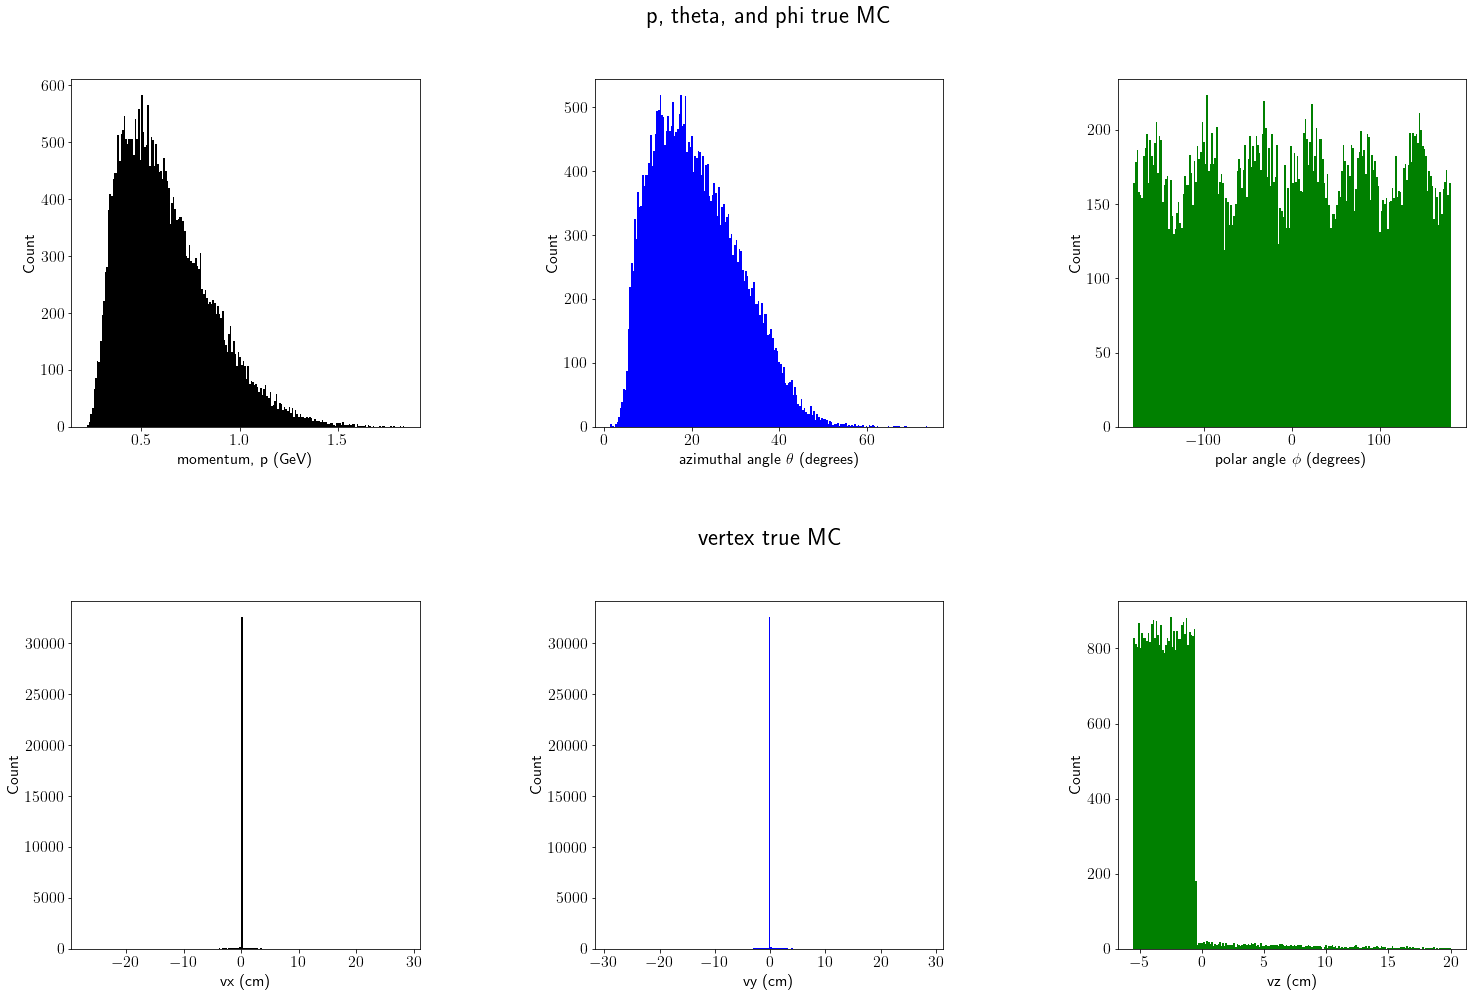

In [38]:
# Create a grid of subplots
fig1, axs1 = plt.subplots(2, 3, figsize=(25, 16))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

axs1[0,0].hist(p_true, bins=200, color="black")
axs1[0,0].set_xlabel("momentum, p (GeV)")
axs1[0,0].set_ylabel("Count")

axs1[0,1].hist(theta_true, bins=200, color="blue")
axs1[0,1].set_xlabel(r"azimuthal angle $\theta$ (degrees)")
axs1[0,1].set_ylabel("Count")

axs1[0,1].set_title("p, theta, and phi true MC\n\n", loc='center', fontsize=24)

axs1[0,2].hist(phi_true, bins=200, color="green")
axs1[0,2].set_xlabel("polar angle $\phi$ (degrees)")
axs1[0,2].set_ylabel("Count")


axs1[1,0].hist(vx, bins=200, color="black")
axs1[1,0].set_xlabel("vx (cm)")
axs1[1,0].set_ylabel("Count")

axs1[1,1].hist(vy, bins=200, color="blue")
axs1[1,1].set_xlabel("vy (cm)")
axs1[1,1].set_ylabel("Count")

axs1[1,1].set_title("vertex true MC\n\n", loc='center', fontsize=24)

axs1[1,2].hist(np.array(vz)[np.array(vz) < 20], bins=200, color="green")
axs1[1,2].set_xlabel("vz (cm)")
axs1[1,2].set_ylabel("Count")

plt.show()

# Data processing

In [15]:
def normalize_2d_list(data):
    # Find the global minimum and maximum values for all variables
    flat_data = [item for sublist in data for item in sublist]
    global_min = min(flat_data)
    global_max = max(flat_data)

    # Normalize the data
    normalized_data = [[(value - global_min) / (global_max - global_min) for value in row] for row in data]

    return normalized_data

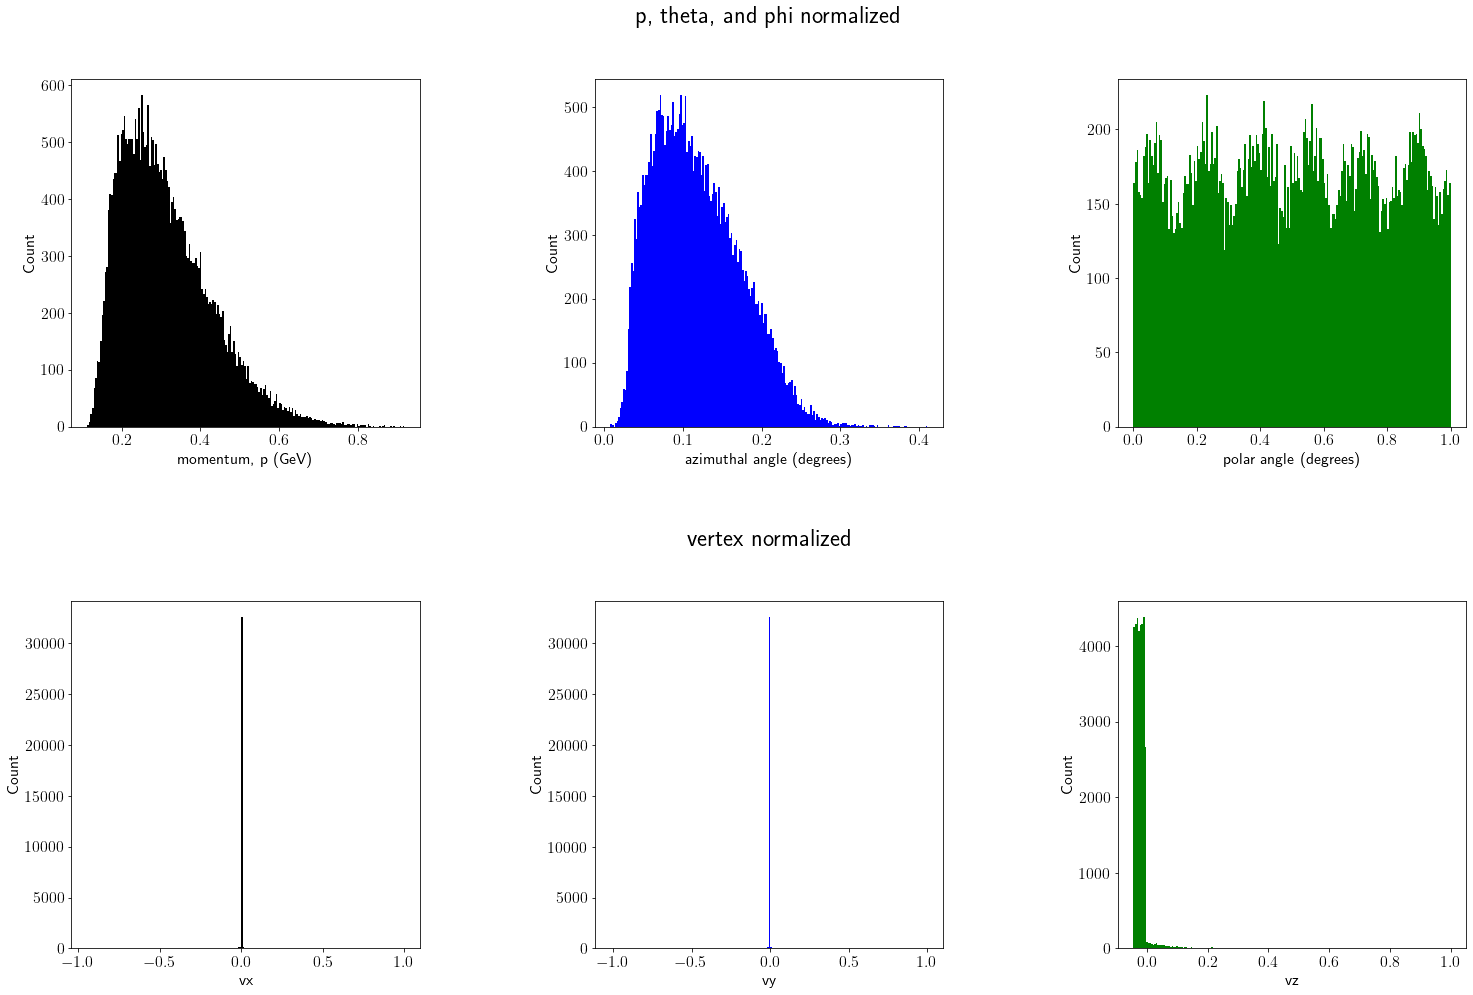

In [16]:
# normalize data

# training with MC data

# normalize input data
x_normalized = normalize_2d_list(x)
y_normalized = normalize_2d_list(y)
z_normalized = normalize_2d_list(z)

# normalize vertex output data
vx_max = max(vx)
vy_max = max(vy)
vz_max = max(vz)

vx_normalized = [filler / vx_max for filler in vx]
vy_normalized = [filler / vy_max for filler in vy]
vz_normalized = [filler / vz_max for filler in vz]


# Normalize theta values to the range [0, 1]
theta_true_normalized = [theta / 180 for theta in theta_true]

# Normalize phi values to the range [0, 1]
phi_true_normalized = [(phi + 180) / 360 for phi in phi_true]

# Normalize p values to the range [0, 1]
p_true_normalized = [p / 2 for p in p_true]

# RECON
# Normalize theta values to the range [0, 1]
theta_recon_normalized = [theta / 180 for theta in theta_recon]

# Normalize phi values to the range [0, 1]
phi_recon_normalized = [(phi + 180) / 360 for phi in phi_recon]

# Normalize p values to the range [0, 1]
p_recon_normalized = [p / 2 for p in p_recon]

# Create a grid of subplots
fig1, axs1 = plt.subplots(2, 3, figsize=(25, 16))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

axs1[0,0].hist(p_true_normalized, bins=200, color="black")
axs1[0,0].set_xlabel("momentum, p (GeV)")
axs1[0,0].set_ylabel("Count")

axs1[0,1].hist(theta_true_normalized, bins=200, color="blue")
axs1[0,1].set_xlabel("azimuthal angle (degrees)")
axs1[0,1].set_ylabel("Count")

axs1[0,1].set_title("p, theta, and phi normalized\n\n", loc='center', fontsize=24)

axs1[0,2].hist(phi_true_normalized, bins=200, color="green")
axs1[0,2].set_xlabel("polar angle (degrees)")
axs1[0,2].set_ylabel("Count")


axs1[1,0].hist(vx_normalized, bins=200, color="black")
axs1[1,0].set_xlabel("vx")
axs1[1,0].set_ylabel("Count")

axs1[1,1].hist(vy_normalized, bins=200, color="blue")
axs1[1,1].set_xlabel("vy")
axs1[1,1].set_ylabel("Count")

axs1[1,1].set_title("vertex normalized\n\n", loc='center', fontsize=24)

axs1[1,2].hist(vz_normalized, bins=200, color="green")
axs1[1,2].set_xlabel("vz")
axs1[1,2].set_ylabel("Count")

plt.show()

In [17]:
# splitting data into training data (70%), validation data (10%), and testing data (20%)

split_index_1_i = int(len(x_normalized) * 0.7)
split_index_2_i = int(len(x_normalized) * 0.8)

split_index_1_o = int(len(p_true_normalized) * 0.7)
split_index_2_o = int(len(p_true_normalized) * 0.8)

x_training = x_normalized[:split_index_1_i]
x_validation = x_normalized[split_index_1_i:split_index_2_i]
x_test = x_normalized[split_index_2_i:]
y_training = y_normalized[:split_index_1_i]
y_validation = y_normalized[split_index_1_i:split_index_2_i]
y_test = y_normalized[split_index_2_i:]
z_training = z_normalized[:split_index_1_i]
z_validation = z_normalized[split_index_1_i:split_index_2_i]
z_test = z_normalized[split_index_2_i:]

p_input_training = [[item] for item in p_recon_normalized[:split_index_1_i]]
p_input_validation = [[item] for item in p_recon_normalized[split_index_1_i:split_index_2_i]]
p_input_test = [[item] for item in p_recon_normalized[split_index_2_i:]]
theta_input_training = [[item] for item in theta_recon_normalized[:split_index_1_i]]
theta_input_validation = [[item] for item in theta_recon_normalized[split_index_1_i:split_index_2_i]]
theta_input_test = [[item] for item in theta_recon_normalized[split_index_2_i:]]
phi_input_training = [[item] for item in phi_recon_normalized[:split_index_1_i]]
phi_input_validation = [[item] for item in phi_recon_normalized[split_index_1_i:split_index_2_i]]
phi_input_test = [[item] for item in phi_recon_normalized[split_index_2_i:]]

p_training = p_true_normalized[:split_index_1_o]
p_validation = p_true_normalized[split_index_1_o:split_index_2_o]
p_test = p_true_normalized[split_index_2_o:]
theta_training = theta_true_normalized[:split_index_1_o]
theta_validation = theta_true_normalized[split_index_1_o:split_index_2_o]
theta_test = theta_true_normalized[split_index_2_o:]
phi_training = phi_true_normalized[:split_index_1_o]
phi_validation = phi_true_normalized[split_index_1_o:split_index_2_o]
phi_test = phi_true_normalized[split_index_2_o:]

vx_training = vx_normalized[:split_index_1_o]
vx_validation = vx_normalized[split_index_1_o:split_index_2_o]
vx_test = vx_normalized[split_index_2_o:]
vy_training = vy_normalized[:split_index_1_o]
vy_validation = vy_normalized[split_index_1_o:split_index_2_o]
vy_test = vy_normalized[split_index_2_o:]
vz_training = vz_normalized[:split_index_1_o]
vz_validation = vz_normalized[split_index_1_o:split_index_2_o]
vz_test = vz_normalized[split_index_2_o:]

In [18]:
# input for training the neural network
xyz_training = [sublist1 + sublist2 + sublist3 + sublist4 + sublist5 + sublist6 for sublist1, sublist2, sublist3, sublist4, sublist5, sublist6
                in zip(x_training, y_training, z_training, p_input_training, theta_input_training, phi_input_training)]  

# output labels for training the net
# ALSO includes vertex data now
p_theta_phi_training = [[0,0,0,0,0,0] for i in range(0, len(p_training))]
for i,_ in enumerate(p_training):
    p_theta_phi_training[i][0] = p_training[i]
    p_theta_phi_training[i][1] = theta_training[i]
    p_theta_phi_training[i][2] = phi_training[i]
    p_theta_phi_training[i][3] = vx_training[i]
    p_theta_phi_training[i][4] = vy_training[i]
    p_theta_phi_training[i][5] = vz_training[i]

# validation input data
xyz_validation = [sublist1 + sublist2 + sublist3 + sublist4 + sublist5 + sublist6 for sublist1, sublist2, sublist3, sublist4, sublist5, sublist6
                in zip(x_validation, y_validation, z_validation, p_input_validation, theta_input_validation, phi_input_validation)]  
# validation output data
p_theta_phi_validation = [[0,0,0,0,0,0] for i in range(0, len(p_validation))]
for i,_ in enumerate(p_validation):
    p_theta_phi_validation[i][0] = p_validation[i]
    p_theta_phi_validation[i][1] = theta_validation[i]
    p_theta_phi_validation[i][2] = phi_validation[i]
    p_theta_phi_validation[i][3] = vx_validation[i]
    p_theta_phi_validation[i][4] = vy_validation[i]
    p_theta_phi_validation[i][5] = vz_validation[i]

# test input data
xyz_test = [sublist1 + sublist2 + sublist3 + sublist4 + sublist5 + sublist6 for sublist1, sublist2, sublist3, sublist4, sublist5, sublist6
                in zip(x_test, y_test, z_test, p_input_test, theta_input_test, phi_input_test)]  
# test output data
p_theta_phi_test = [[0,0,0,0,0,0] for i in range(0, len(p_test))]
for i,_ in enumerate(p_test):
    p_theta_phi_test[i][0] = p_test[i]
    p_theta_phi_test[i][1] = theta_test[i]
    p_theta_phi_test[i][2] = phi_test[i]
    p_theta_phi_test[i][3] = vx_test[i]
    p_theta_phi_test[i][4] = vy_test[i]
    p_theta_phi_test[i][5] = vz_test[i]


# Convert training input data to a list of arrays
xyz_training = [np.array(sublist, dtype=float) for sublist in xyz_training]

# Convert training output labels to a list of arrays
p_theta_phi_training = [np.array(sublist, dtype=float) for sublist in p_theta_phi_training]

# Convert validation input data to a list of arrays
xyz_validation = [np.array(sublist, dtype=float) for sublist in xyz_validation]

# Convert validation output labels to a list of arrays
p_theta_phi_validation = [np.array(sublist, dtype=float) for sublist in p_theta_phi_validation]

# Convert test input data to a list of arrays
xyz_test = [np.array(sublist, dtype=float) for sublist in xyz_test]

# Convert test output labels to a list of arrays
p_theta_phi_test = [np.array(sublist, dtype=float) for sublist in p_theta_phi_test]

## xyz 2D lists now include normalized p, theta, and phi recon values as inputs

In [19]:
# Find the maximum sequence length
max_sequence_length = max(len(seq) for seq in xyz_training + xyz_validation + xyz_test)

# Pad sequences to the maximum length

xyz_training = pad_sequences(xyz_training, maxlen=max_sequence_length, dtype=float)
xyz_validation = pad_sequences(xyz_validation, maxlen=max_sequence_length, dtype=float)
xyz_test = pad_sequences(xyz_test, maxlen=max_sequence_length, dtype=float)


In [20]:
print(len(xyz_training), len(xyz_training[0]), len(p_theta_phi_training), len(p_theta_phi_training[0]))

23800 36 23800 6


# Neural Network

In [21]:
model = keras.Sequential()

input_dim = len(xyz_training[0])                       # input dimension depending on the amount of tracking data pulled from each event in REC::Traj
output_dim = len(p_theta_phi_training[0])              # p, theta, phi, vx, vy, and vz

model.add(keras.layers.Dense(units=64, activation='relu', input_shape=(input_dim,))) 
model.add(keras.layers.Dense(units=64, activation='relu')) 
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=64, activation='relu')) 
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=output_dim, activation='linear')) # linear activation?

2023-07-25 10:47:55.683753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-07-25 10:47:55.683810: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-25 10:47:55.683850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (farm180246.jlab.org): /proc/driver/nvidia/version does not exist
2023-07-25 10:47:55.684408: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.compile(loss='mean_absolute_error', optimizer='adam') # 'mean_squared_error' if the data isn't normalized

In [23]:
# fitting the neural network
model.fit(xyz_training, np.array(p_theta_phi_training), batch_size=64, epochs=10, validation_data=(xyz_validation, np.array(p_theta_phi_validation)))

Epoch 1/10
372/372 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0111
Epoch 2/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 3/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 4/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 5/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 6/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 7/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 8/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0090
Epoch 9/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 10/10
372/372 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0084

In [24]:
loss= model.evaluate(xyz_test, np.array(p_theta_phi_test))

213/213 [==============================] - 0s 731us/step - loss: 0.0090


In [25]:
# predicting
predictions_normalized = model.predict(xyz_test)
print(predictions_normalized)  

[[ 2.24792942e-01  1.27143785e-01  2.69677192e-01 -1.19792961e-03
   4.09616565e-04 -2.30268911e-02]
 [ 3.05938333e-01  9.32446271e-02  5.17390072e-02 -2.82122754e-03
  -1.04657258e-04 -2.46308595e-02]
 [ 6.37151957e-01  4.46101353e-02  7.45535135e-01 -4.17947583e-03
  -4.69266000e-04 -2.60275230e-02]
 ...
 [ 3.87850851e-01  1.51186258e-01  6.00495674e-02 -2.77187210e-03
  -4.11733316e-04 -2.71423087e-02]
 [ 3.89876932e-01  7.54270330e-02  4.06736195e-01 -2.36972002e-03
  -6.56612334e-04 -2.40838192e-02]
 [ 1.89039439e-01  2.00779915e-01  5.24186194e-01 -2.16157455e-03
   1.02549755e-04 -2.22214852e-02]]


In [26]:
p_predictions_normalized = []
theta_predictions_normalized = []
phi_predictions_normalized = []

vx_predictions_normalized = []
vy_predictions_normalized = []
vz_predictions_normalized = []

for _,v in enumerate(predictions_normalized):
    p_predictions_normalized.append(v[0])
    theta_predictions_normalized.append(v[1])
    phi_predictions_normalized.append(v[2])
    vx_predictions_normalized.append(v[3])
    vy_predictions_normalized.append(v[4])
    vz_predictions_normalized.append(v[5])

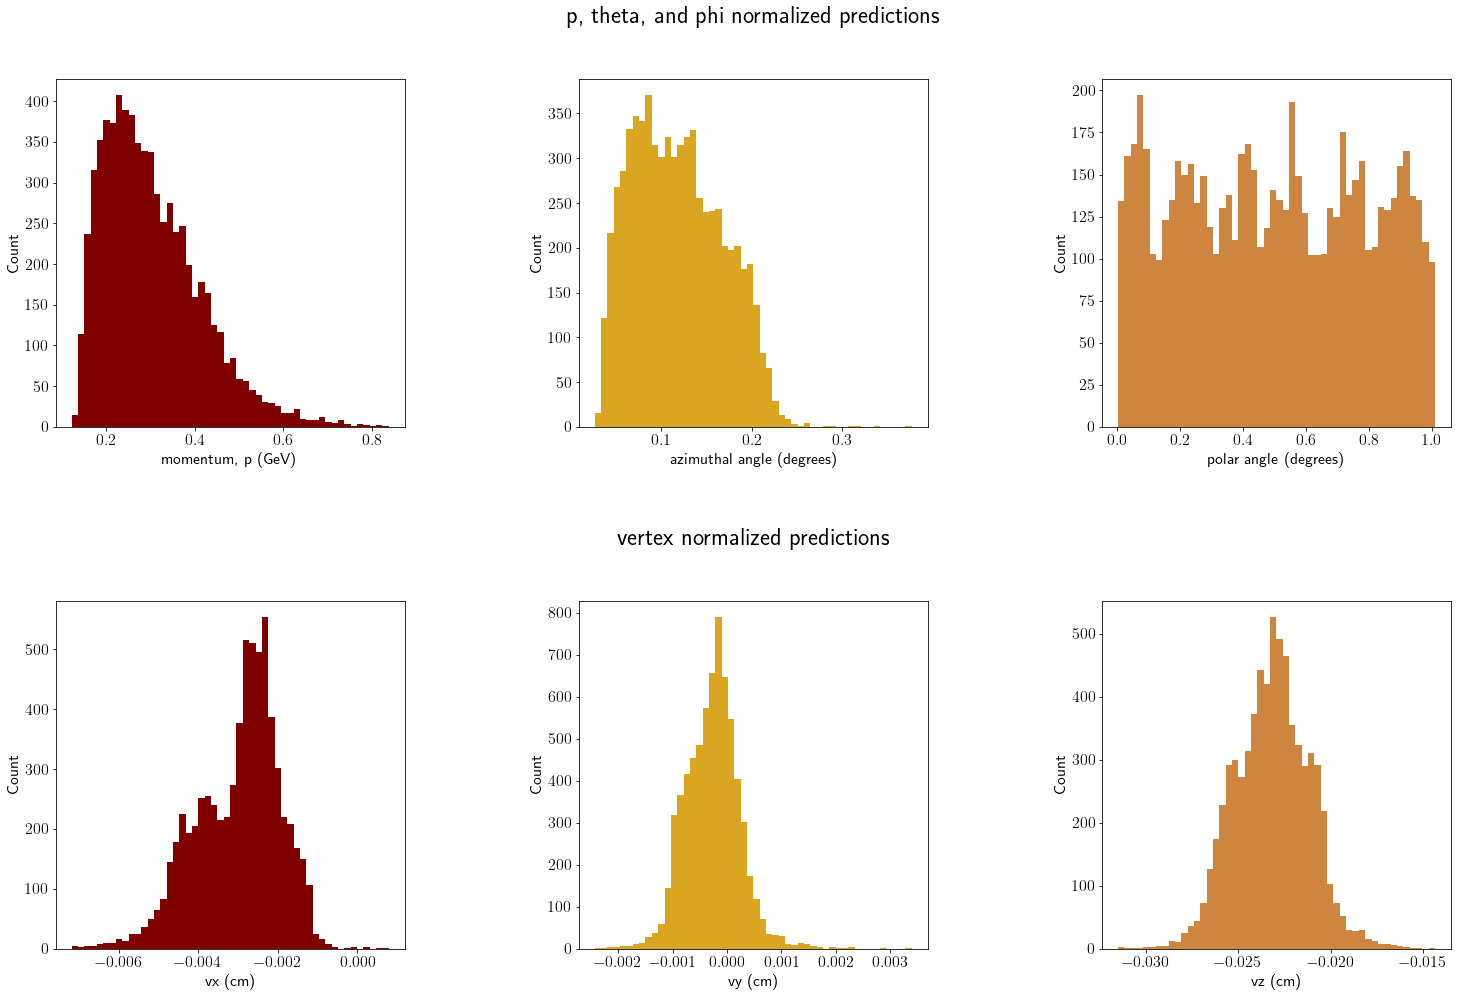

In [39]:
# Create a grid of subplots
fig1, axs1 = plt.subplots(2, 3, figsize=(25, 16))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

axs1[0,0].hist(p_predictions_normalized, bins=50, color="maroon")
axs1[0,0].set_xlabel("momentum, p (GeV)")
axs1[0,0].set_ylabel("Count")

axs1[0,1].hist(theta_predictions_normalized, bins=50, color="goldenrod")
axs1[0,1].set_xlabel("azimuthal angle (degrees)")
axs1[0,1].set_ylabel("Count")

axs1[0,1].set_title("p, theta, and phi normalized predictions\n\n", loc='center', fontsize=24)

axs1[0,2].hist(phi_predictions_normalized, bins=50, color="peru")
axs1[0,2].set_xlabel("polar angle (degrees)")
axs1[0,2].set_ylabel("Count")


axs1[1,0].hist(vx_predictions_normalized, bins=50, color="maroon")
axs1[1,0].set_xlabel("vx (cm)")
axs1[1,0].set_ylabel("Count")

axs1[1,1].hist(vy_predictions_normalized, bins=50, color="goldenrod")
axs1[1,1].set_xlabel("vy (cm)")
axs1[1,1].set_ylabel("Count")

axs1[1,1].set_title("vertex normalized predictions\n\n", loc='center', fontsize=24)

axs1[1,2].hist(vz_predictions_normalized, bins=50, color="peru")
axs1[1,2].set_xlabel("vz (cm)")
axs1[1,2].set_ylabel("Count")

plt.show()

In [28]:
# un-normalize data

# Un-normalize p values to the range [0, 2]
p_predictions = [p * 2 for p in p_predictions_normalized]

# Un-normalize theta values to the range [0, 180]
theta_predictions = [theta * 180 for theta in theta_predictions_normalized]

# Un-normalize phi values to the range [-180, 180]
phi_predictions = [phi * 360 - 180 for phi in phi_predictions_normalized]

# Un-normalize vx, vy, vz
vx_predictions = [filler * vx_max for filler in vx_predictions_normalized]

vy_predictions = [filler * vy_max for filler in vy_predictions_normalized]

vz_predictions = [filler * vz_max for filler in vz_predictions_normalized]

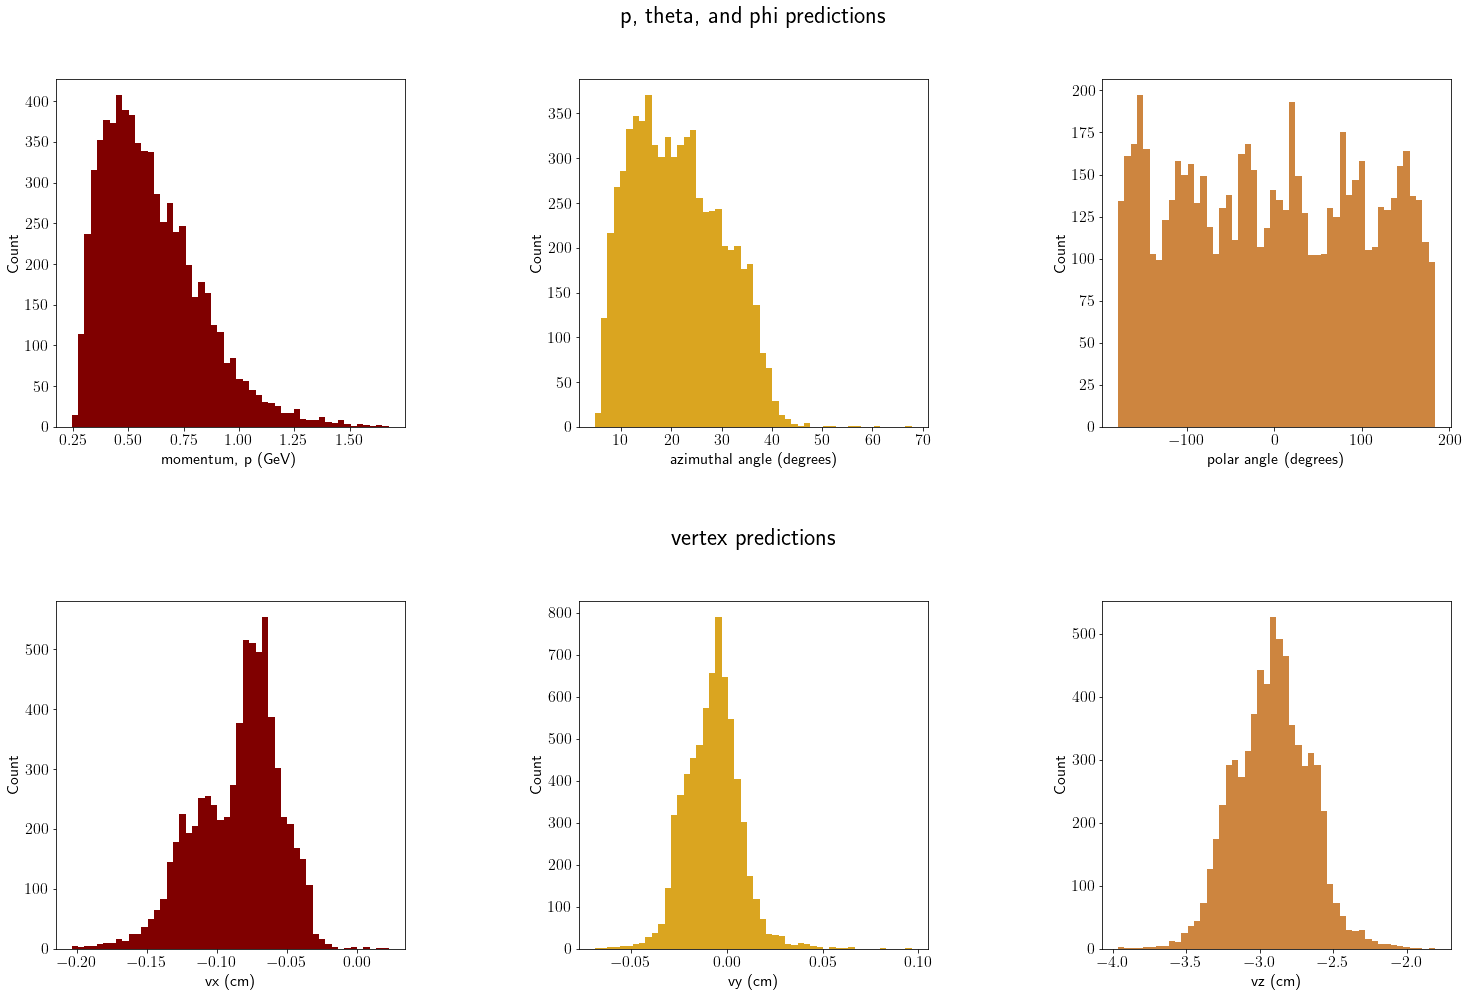

In [40]:
# Create a grid of subplots
fig1, axs1 = plt.subplots(2, 3, figsize=(25, 16))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

axs1[0,0].hist(p_predictions, bins=50, color="maroon")
axs1[0,0].set_xlabel("momentum, p (GeV)")
axs1[0,0].set_ylabel("Count")

axs1[0,1].hist(theta_predictions, bins=50, color="goldenrod")
axs1[0,1].set_xlabel("azimuthal angle (degrees)")
axs1[0,1].set_ylabel("Count")

axs1[0,1].set_title("p, theta, and phi predictions\n\n", loc='center', fontsize=24)

axs1[0,2].hist(phi_predictions, bins=50, color="peru")
axs1[0,2].set_xlabel("polar angle (degrees)")
axs1[0,2].set_ylabel("Count")


axs1[1,0].hist(vx_predictions, bins=50, color="maroon")
axs1[1,0].set_xlabel("vx (cm)")
axs1[1,0].set_ylabel("Count")

axs1[1,1].hist(vy_predictions, bins=50, color="goldenrod")
axs1[1,1].set_xlabel("vy (cm)")
axs1[1,1].set_ylabel("Count")

axs1[1,1].set_title("vertex predictions\n\n", loc='center', fontsize=24)

axs1[1,2].hist(vz_predictions, bins=50, color="peru")
axs1[1,2].set_xlabel("vz (cm)")
axs1[1,2].set_ylabel("Count")

plt.show()

In [30]:
len(xyz_test)

6801

# checking resolution
### where to go next? how?

In [31]:
print("p vector lengths:", len(p_true), len(p_predictions), (len(p_true) * len(p_predictions)))

p vector lengths: 34001 6801 231240801


In [32]:
# matching with cutoffs |theta_mc-theta_rec|<2deg and |phi_mc-phi_rec|<6deg, minimize quadrature sum error
# change matching formula to also include momentum? |p_true - p_predictions|<0.05 GeV

start_time = timeit.default_timer()

p_predictions_changing = p_predictions[:]
theta_predictions_changing = theta_predictions[:]
phi_predictions_changing = phi_predictions[:]

matching_indices = np.zeros((2, len(p_true)), dtype=int)
unmatched_indices = np.array([], dtype=int)
num_matches = 0

# going through all the "true" pions
for i,_ in enumerate(p_true):
    
    min_quad_error = 1000 # arbitrary large number
    for j,_ in enumerate(p_predictions): # for each true pion, look through every predicted pion
        
        theta_error = theta_true[i] - theta_predictions_changing[j]
        phi_error = phi_true[i] - phi_predictions_changing[j]
        p_error = p_true[i] - p_predictions_changing[j] 
        
        if (abs(theta_error) < 2 or abs(theta_error) > 178) & (abs(phi_error) < 6 or abs(phi_error) > 354): # does this true pion have a similar predicted pion, based on their angles?
            min_quad_error_temp = np.sqrt((theta_error) ** 2 + (phi_error) ** 2) + 10 * p_error # in case there are multiple hits, we can minimize based off a quadrature sum
            if (min_quad_error_temp < min_quad_error):
                min_quad_error = min_quad_error_temp
                predictions_index = j # saving the matched index of the "best" predicted pion
                
    if (min_quad_error < 1000): # if there were any matches for this true pion, essentially
        matching_indices[0][num_matches] = i
        matching_indices[1][num_matches] = predictions_index # saving the matching indices of the true and predicted pions
        
        p_predictions_changing[predictions_index] = 100
        theta_predictions_changing[predictions_index] = 100
        phi_predictions_changing[predictions_index] = 100  # this is my way of avoiding duplicates - obviously angles of 3000 degrees will not be put as a match to other pions going forward
        
        num_matches += 1
    else:
        unmatched_indices = np.append(unmatched_indices, [i])
        
matching_indices = matching_indices[:, :num_matches]

print("time computing", timeit.default_timer() - start_time)
print(matching_indices)
print(len(p_true) * len(p_predictions))

time computing 169.50918583851308
[[    0     1     2 ... 11257 11531 13865]
 [ 2694  1952  1176 ...  5577  2806  6317]]
231240801


In [33]:
# finding the difference between the true and predicted data
p_difference = []
theta_difference = []
phi_difference = []

for i,_ in enumerate(matching_indices[1]):
    p_difference.append(p_true[matching_indices[0][i]] - p_predictions[matching_indices[1][i]])
    theta_difference.append(theta_true[matching_indices[0][i]] - theta_predictions[matching_indices[1][i]])
    phi_difference.append(phi_true[matching_indices[0][i]] - phi_predictions[matching_indices[1][i]])

p_difference = np.array(p_difference)
theta_difference = np.array(theta_difference)
phi_difference = np.array(phi_difference)


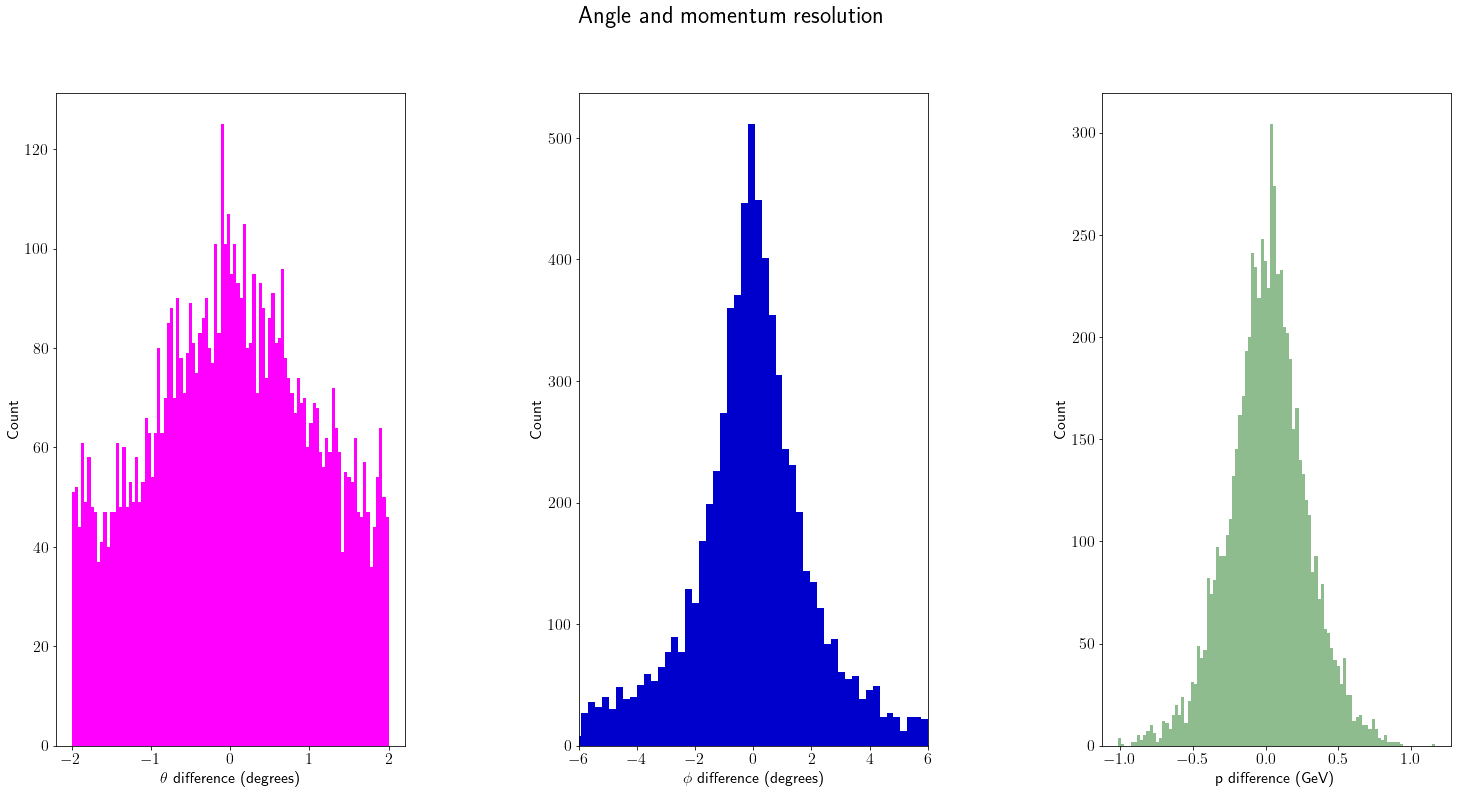

In [34]:
# Create a grid of subplots
fig1, axs1 = plt.subplots(1, 3, figsize=(25, 12))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

# predicted data resolution histograms

axs1[0].hist(theta_difference, bins=100, color="fuchsia")
axs1[0].set_ylabel("Count")
axs1[0].set_xlabel(r"$\theta$ difference (degrees)")

axs1[1].hist(phi_difference, bins=3000, color="mediumblue")
axs1[1].set_ylabel("Count")
axs1[1].set_xlabel(r"$\phi$ difference (degrees)")
axs1[1].set_xlim(-6, 6)

axs1[2].hist(p_difference, bins=100, color="darkseagreen")
axs1[2].set_ylabel("Count")
axs1[2].set_xlabel(r"p difference (GeV)")


plt.suptitle("Angle and momentum resolution", fontsize=24)

plt.show()